In [1]:
pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.preprocessing import LabelEncoder
from torchvision.models import resnet18, ResNet18_Weights

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.nn.module import to_pyro_module_
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal

from tqdm.auto import tqdm
import kagglehub # Assuming this is available in your environment


In [3]:
# --- Data Preprocessing (from your prompt) ---
# This section is included for completeness and should be run before the BNN part.

# Define the base path to your dataset
# For demonstration, let's assume 'path' from your prompt is the directory containing the dataset.
# If running in a different environment, adjust this path.
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")
dataset_base_path = path

# List of your class names (folder names)
class_names = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Initialize lists to store image data and corresponding labels
all_images = []
all_labels = []

# Define the target size for resizing images
TARGET_SIZE = (128, 128)

print("--- Step 1: Loading and Resizing Images ---")

# Loop through each class (folder)
for class_name in class_names:
    class_folder_path = os.path.join(dataset_base_path, class_name)
    print(f"Processing folder: {class_folder_path}")

    if not os.path.exists(class_folder_path):
        print(f"Warning: Folder '{class_folder_path}' not found. Skipping.")
        continue

    for item_name in os.listdir(class_folder_path):
        item_path = os.path.join(class_folder_path, item_name)

        if os.path.isfile(item_path) and item_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image = cv2.imread(item_path, 0) # Read in grayscale (0)

            if image is not None:
                image = cv2.resize(image, TARGET_SIZE)
                image = image / 255.0  # Normalize to [0, 1]
                image = image.astype(np.float32)
                image = np.expand_dims(image, axis=-1)
                all_images.append(image)
                all_labels.append(class_name)
            else:
                print(f"Warning: Could not load image {item_path}. Skipping.")

print(f"\nLoaded {len(all_images)} images.")
print(f"Loaded {len(all_labels)} labels.")

# Convert to NumPy arrays
all_images_np = np.array(all_images)
all_labels_np = np.array(all_labels)

print(f"Shape of image array: {all_images_np.shape}")
print(f"Shape of label array: {all_labels_np.shape}")

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels_np)
num_classes = len(label_encoder.classes_)
print(f"Encoded labels: {encoded_labels[:5]}")
print(f"Number of classes: {num_classes}")

# Convert to PyTorch Tensors
images_tensor = torch.from_numpy(all_images_np).permute(0, 3, 1, 2)
labels_tensor = torch.from_numpy(encoded_labels).long()
print(f"Shape of image tensor: {images_tensor.shape}")
print(f"Shape of label tensor: {labels_tensor.shape}")

# Create a TensorDataset
dataset = TensorDataset(images_tensor, labels_tensor)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

from torchvision import transforms

# Define data augmentation transforms for training data
train_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    # Convert grayscale to 3 channels by repeating the single channel, as ResNet expects 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

# Define transforms for testing data (no augmentation)
test_transforms = transforms.Compose([
    # Convert grayscale to 3 channels by repeating the single channel
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

# Apply transforms to the datasets
# We need to recreate the TensorDatasets with applied transforms
# This requires accessing the underlying tensors of the train_dataset and test_dataset splits.
# The original train_dataset and test_dataset are Subset objects, so we access their dataset and indices.

# Get the original dataset and the indices for train and test splits
original_dataset = dataset
train_indices = train_dataset.indices
test_indices = test_dataset.indices

# Create new datasets with transforms applied
class TransformedTensorDataset(TensorDataset):
    def __init__(self, tensors, transform=None):
        super().__init__(*tensors)
        self.transform = transform

    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset_transformed = TransformedTensorDataset(
    [original_dataset.tensors[0][train_indices], original_dataset.tensors[1][train_indices]],
    transform=train_transforms
)

test_dataset_transformed = TransformedTensorDataset(
    [original_dataset.tensors[0][test_indices], original_dataset.tensors[1][test_indices]],
    transform=test_transforms
)


# Recreate DataLoaders with the transformed datasets
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset_transformed, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False)

print("\nData augmentation applied and DataLoaders updated.")
print(f"Shape of augmented training data batches: {next(iter(train_loader))[0].shape}")
print(f"Shape of test data batches: {next(iter(test_loader))[0].shape}")


100%|██████████| 236M/236M [00:12<00:00, 20.4MB/s]

Extracting files...


--- Step 1: Loading and Resizing Images ---
Processing folder: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1/glioma
Processing folder: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1/healthy
Processing folder: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1/meningioma
Processing folder: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1/pituitary

Loaded 7023 images.
Loaded 7023 labels.
Shape of image array: (7023, 128, 128, 1)
Shape of label array: (7023,)
Encoded labels: [0 0 0 0 0]
Number of classes: 4
Shape of image tensor: torch.Size([7023, 1, 128, 128])
Shape of label tensor: torch.Size([7023])
Training dataset size: 5618
Testing dataset size: 1405

Data augmentation applied and DataLoaders updated.
Shape of augmented training data batches: torch.Size([32, 3, 128, 128])
Shape of test data batches: torch.Size([32, 3, 128, 128])


In [4]:
# Set a random seed for reproducibility
pyro.set_rng_seed(42)
torch.manual_seed(42)

In [5]:
# --- Step 2: Define the Bayesian ResNet18 Model ---
print("\n--- Step 2: Defining the Bayesian ResNet18 Model ---")

class BayesianResNet18(PyroModule):
    def __init__(self, num_classes):
        super().__init__()
        # Load a pre-trained ResNet18 model
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the first convolutional layer for 3-channel RGB input
        # This is the default for ResNet, so we reset it to the default
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


        # Replace the final fully connected layer to match the number of classes
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        # Convert the standard PyTorch model to a PyroModule.
        # This replaces all standard nn.Modules with their PyroModule counterparts.
        to_pyro_module_(self.resnet)

        # Here we make the final classification layer Bayesian by replacing it
        # with PyroSample, which defines a distribution over the weights and biases.
        # We use a Normal prior distribution.
        self.resnet.fc = PyroModule[nn.Linear](num_ftrs, num_classes)
        # Move the parameters of the prior distribution to the GPU
        self.resnet.fc.weight = PyroSample(dist.Normal(torch.tensor(0., device="cuda"), torch.tensor(1., device="cuda")).expand([num_classes, num_ftrs]).to_event(2))
        self.resnet.fc.bias = PyroSample(dist.Normal(torch.tensor(0., device="cuda"), torch.tensor(10., device="cuda")).expand([num_classes]).to_event(1))


    def forward(self, x, y=None):
        # The forward pass simply calls the wrapped ResNet
        x = self.resnet(x)
        # We model the output with a Categorical distribution
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
        return obs


--- Step 2: Defining the Bayesian ResNet18 Model ---


In [6]:
# Instantiate the model and move it to the GPU
bnn_model = BayesianResNet18(4).to("cuda")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


In [7]:
# --- Step 3: Define the Pyro Guide and SVI ---
print("--- Step 3: Defining the Pyro Guide and SVI ---")

# Use a guide that approximates the posterior with a diagonal normal distribution.
# This is a common and effective choice for SVI.
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(bnn_model)

# Set up the optimizer. Adam is a good choice.
learning_rate = 1e-3
adam_params = {"lr": learning_rate}
optimizer = Adam(adam_params)

# Setup SVI (Stochastic Variational Inference) with ELBO loss
svi = SVI(bnn_model, guide, optimizer, loss=Trace_ELBO())

--- Step 3: Defining the Pyro Guide and SVI ---


In [8]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 50

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 3768.1638


Epoch 2/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 3397.6777


Epoch 3/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 3127.2607


Epoch 4/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 2904.5383


Epoch 5/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 2681.2124


Epoch 6/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 2420.1616


Epoch 7/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 2153.4846


Epoch 8/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 1882.9504


Epoch 9/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 1662.2415


Epoch 10/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 1471.6803


Epoch 11/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 11 finished. Average loss: 1308.8785


Epoch 12/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 12 finished. Average loss: 1153.6442


Epoch 13/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 13 finished. Average loss: 1022.2522


Epoch 14/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 14 finished. Average loss: 914.9192


Epoch 15/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 15 finished. Average loss: 849.6737


Epoch 16/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 16 finished. Average loss: 818.0262


Epoch 17/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 17 finished. Average loss: 788.8805


Epoch 18/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 18 finished. Average loss: 763.7075


Epoch 19/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 19 finished. Average loss: 742.9758


Epoch 20/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 20 finished. Average loss: 725.8268


Epoch 21/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 21 finished. Average loss: 713.5630


Epoch 22/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 22 finished. Average loss: 702.8636


Epoch 23/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 23 finished. Average loss: 689.3557


Epoch 24/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 24 finished. Average loss: 675.1623


Epoch 25/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 25 finished. Average loss: 668.8803


Epoch 26/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 26 finished. Average loss: 664.4645


Epoch 27/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 27 finished. Average loss: 656.2447


Epoch 28/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 28 finished. Average loss: 643.4954


Epoch 29/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 29 finished. Average loss: 638.7470


Epoch 30/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 30 finished. Average loss: 633.0080


Epoch 31/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 31 finished. Average loss: 625.9866


Epoch 32/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 32 finished. Average loss: 617.6115


Epoch 33/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 33 finished. Average loss: 605.5103


Epoch 34/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 34 finished. Average loss: 606.1873


Epoch 35/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 35 finished. Average loss: 602.4754


Epoch 36/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 36 finished. Average loss: 597.9785


Epoch 37/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 37 finished. Average loss: 592.1112


Epoch 38/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 38 finished. Average loss: 590.8833


Epoch 39/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 39 finished. Average loss: 586.3730


Epoch 40/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 40 finished. Average loss: 583.7990


Epoch 41/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 41 finished. Average loss: 577.9553


Epoch 42/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 42 finished. Average loss: 579.2116


Epoch 43/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 43 finished. Average loss: 572.9116


Epoch 44/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 44 finished. Average loss: 569.5057


Epoch 45/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 45 finished. Average loss: 571.2159


Epoch 46/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 46 finished. Average loss: 565.3516


Epoch 47/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 47 finished. Average loss: 567.5287


Epoch 48/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 48 finished. Average loss: 568.6510


Epoch 49/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 49 finished. Average loss: 565.8725


Epoch 50/50:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 50 finished. Average loss: 565.1995


In [10]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 20

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 563.9648


Epoch 2/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 562.4462


Epoch 3/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 561.2491


Epoch 4/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 561.4440


Epoch 5/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 556.4698


Epoch 6/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 557.7808


Epoch 7/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 550.7843


Epoch 8/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 549.9065


Epoch 9/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 554.8399


Epoch 10/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 568.3065


Epoch 11/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 11 finished. Average loss: 560.8137


Epoch 12/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 12 finished. Average loss: 555.3285


Epoch 13/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 13 finished. Average loss: 555.5883


Epoch 14/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 14 finished. Average loss: 553.8403


Epoch 15/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 15 finished. Average loss: 548.4648


Epoch 16/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 16 finished. Average loss: 550.8473


Epoch 17/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 17 finished. Average loss: 547.8314


Epoch 18/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 18 finished. Average loss: 545.5058


Epoch 19/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 19 finished. Average loss: 544.6006


Epoch 20/20:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 20 finished. Average loss: 546.7106


In [14]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 10

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 544.2378


Epoch 2/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 543.8261


Epoch 3/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 543.4408


Epoch 4/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 545.0673


Epoch 5/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 542.2317


Epoch 6/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 541.4075


Epoch 7/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 542.3740


Epoch 8/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 542.1941


Epoch 9/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 540.0374


Epoch 10/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 541.7430


In [16]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 10

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 539.8838


Epoch 2/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 541.7861


Epoch 3/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 544.7718


Epoch 4/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 543.4604


Epoch 5/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 540.9422


Epoch 6/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 542.6578


Epoch 7/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 539.9606


Epoch 8/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 542.8293


Epoch 9/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 539.7901


Epoch 10/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 540.8564


In [18]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 10

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 540.2277


Epoch 2/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 541.2925


Epoch 3/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 544.0115


Epoch 4/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 540.8105


Epoch 5/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 543.6100


Epoch 6/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 535.9653


Epoch 7/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 539.9289


Epoch 8/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 538.3278


Epoch 9/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 541.8979


Epoch 10/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 540.0619


In [20]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 10

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 541.1269


Epoch 2/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 540.4149


Epoch 3/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 539.7625


Epoch 4/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 539.0484


Epoch 5/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 537.2845


Epoch 6/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 6 finished. Average loss: 541.5894


Epoch 7/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 7 finished. Average loss: 545.6840


Epoch 8/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 8 finished. Average loss: 536.4929


Epoch 9/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 9 finished. Average loss: 539.8074


Epoch 10/10:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 10 finished. Average loss: 540.4997


In [27]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 542.8945


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 538.6155


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 540.6904


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 538.1666


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 536.6920


In [29]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 539.2395


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 538.1367


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 539.5797


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 540.6261


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 540.6818


In [32]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 538.6640


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 539.3440


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 537.8289


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 537.2498


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 537.7808


In [48]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 541.0955


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 536.2053


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 537.4739


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 538.6601


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 538.9102


In [52]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 539.4763


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 538.1437


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 537.6730


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 539.1847


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 539.4599


In [57]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 536.0522


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 539.7101


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 538.8864


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 536.7227


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 539.9264


In [59]:
# --- Step 4: Training Loop ---
print("\n--- Step 4: Training the BNN ---")
NUM_EPOCHS = 5

# Put the model in training mode
bnn_model.train()
guide.train()

for epoch in range(NUM_EPOCHS):
    total_epoch_loss = 0.0
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            # Move data to GPU
            images = images.to("cuda")
            labels = labels.to("cuda")
            # Calculate the SVI loss and perform a step
            loss = svi.step(images, labels)
            total_epoch_loss += loss

            t.set_postfix(avg_loss=total_epoch_loss / (i + 1))

    print(f"Epoch {epoch+1} finished. Average loss: {total_epoch_loss / len(train_loader):.4f}")


--- Step 4: Training the BNN ---


Epoch 1/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 1 finished. Average loss: 534.5252


Epoch 2/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 2 finished. Average loss: 537.7712


Epoch 3/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 3 finished. Average loss: 541.5973


Epoch 4/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 4 finished. Average loss: 538.9131


Epoch 5/5:   0%|          | 0/176 [00:00<?, ?batch/s]

Epoch 5 finished. Average loss: 539.1395


In [60]:
# --- Step 5: Evaluation and Uncertainty Prediction on the entire test set ---
print("\n--- Step 5: Evaluating the BNN and Predicting with Uncertainty on the entire test set ---")

# Put the model in evaluation mode
bnn_model.eval()
guide.eval()

# Create a Pyro Predictive object to draw samples from the posterior
# We'll perform 100 forward passes for each test image
predictive = Predictive(bnn_model, guide=guide, num_samples=100)

all_predictions = []
all_true_labels = []

# Loop through the entire test loader
with tqdm(test_loader, desc="Evaluating on test set", unit="batch") as t:
    for images, labels in t:
        # Move data to GPU
        images = images.to("cuda")
        labels = labels.to("cuda")

        with torch.no_grad():
            # Run the predictive model on the batch
            predictions = predictive(images)

        # Get the samples for the 'obs' site
        posterior_samples = predictions['obs']

        # Take the mode (most frequent class) from the samples for each image in the batch
        mode_predictions = torch.mode(posterior_samples, dim=0).values

        all_predictions.append(mode_predictions.cpu()) # Move predictions back to CPU for concatenation and evaluation
        all_true_labels.append(labels.cpu()) # Move labels back to CPU

# Concatenate all predictions and labels
all_predictions_tensor = torch.cat(all_predictions, dim=0)
all_true_labels_tensor = torch.cat(all_true_labels, dim=0)

# Calculate overall accuracy
correct_predictions = (all_predictions_tensor == all_true_labels_tensor).sum().item()
total_samples = len(all_true_labels_tensor)
accuracy = correct_predictions / total_samples

print(f"\nOverall Accuracy on the entire test set ({total_samples} images): {accuracy * 100:.2f}%")

print("\nEvaluation complete.")


--- Step 5: Evaluating the BNN and Predicting with Uncertainty on the entire test set ---


Evaluating on test set:   0%|          | 0/44 [00:00<?, ?batch/s]


Overall Accuracy on the entire test set (1405 images): 99.22%

Evaluation complete.



--- Classification Report ---
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       336
     healthy       1.00      0.99      1.00       392
  meningioma       0.99      0.99      0.99       350
   pituitary       0.99      1.00      0.99       327

    accuracy                           0.99      1405
   macro avg       0.99      0.99      0.99      1405
weighted avg       0.99      0.99      0.99      1405


--- Confusion Matrix ---


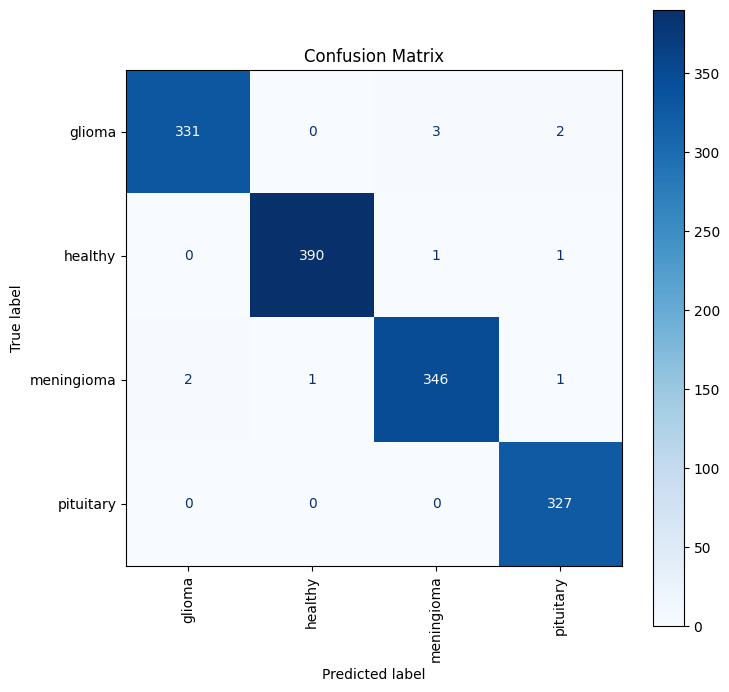

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n--- Classification Report ---")
print(classification_report(all_true_labels_tensor.numpy(), all_predictions_tensor.numpy(), target_names=class_names))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_true_labels_tensor.numpy(), all_predictions_tensor.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


--- Analyzing Misclassifications ---
Found 12 misclassified images out of 1405 test images.

Displaying 10 misclassified images:


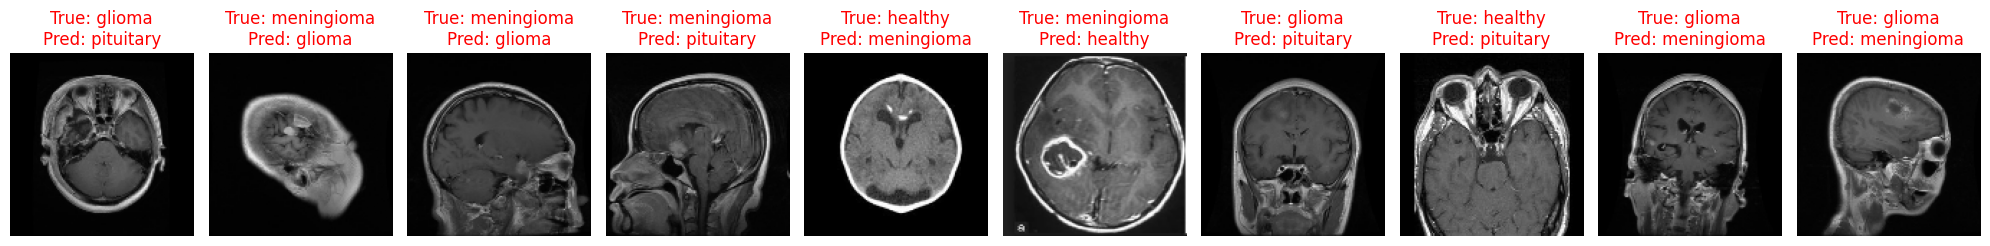


Misclassification analysis complete.


In [62]:
# --- Analyze Misclassifications ---
print("\n--- Analyzing Misclassifications ---")

# Ensure the model and guide are in evaluation mode
bnn_model.eval()
guide.eval()

# Create a Predictive object with a smaller number of samples for quicker analysis
predictive_analysis = Predictive(bnn_model, guide=guide, num_samples=15, return_sites=("obs", "_RETURN"))

misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

# Iterate through the test loader
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Get predictions
        predictions = predictive_analysis(images)['obs']
        mode_predictions = torch.mode(predictions, dim=0).values

        # Identify misclassified samples in the current batch
        misclassified_mask = (mode_predictions != labels)

        # Store misclassified images and labels
        misclassified_images.append(images[misclassified_mask].cpu())
        misclassified_true_labels.append(labels[misclassified_mask].cpu())
        misclassified_predicted_labels.append(mode_predictions[misclassified_mask].cpu())

# Concatenate misclassified data
all_misclassified_images = torch.cat(misclassified_images, dim=0)
all_misclassified_true_labels = torch.cat(misclassified_true_labels, dim=0)
all_misclassified_predicted_labels = torch.cat(misclassified_predicted_labels, dim=0)

print(f"Found {len(all_misclassified_images)} misclassified images out of {len(test_dataset_transformed)} test images.")

# Display some misclassified images
num_images_to_display = min(10, len(all_misclassified_images)) # Display up to 10 misclassified images

if num_images_to_display > 0:
    print(f"\nDisplaying {num_images_to_display} misclassified images:")
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))
    if num_images_to_display == 1:
        axes = [axes] # Make it iterable if there's only one image

    for i in range(num_images_to_display):
        img = all_misclassified_images[i].squeeze().permute(1, 2, 0).numpy() # Permute back to (H, W, C) for displaying
        true_label = label_encoder.inverse_transform([all_misclassified_true_labels[i].item()])[0]
        predicted_label = label_encoder.inverse_transform([all_misclassified_predicted_labels[i].item()])[0]

        # If the image has 3 channels, display as color; otherwise, display as grayscale
        if img.shape[-1] == 3:
            axes[i].imshow(img)
        else:
            axes[i].imshow(img, cmap='gray')

        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}", color='red')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display.")

print("\nMisclassification analysis complete.")

In [63]:
# --- Step 5: Evaluation and Uncertainty Prediction ---
print("\n--- Step 5: Evaluating the BNN and Predicting with Uncertainty ---")

# Put the model in evaluation mode
bnn_model.eval()
guide.eval()

# We will use the test loader to predict
test_images, test_labels = next(iter(test_loader))
num_test_samples = test_images.shape[0]

# Create a Pyro Predictive object to draw samples from the posterior
# For each test image, we'll perform 100 forward passes
predictive = Predictive(bnn_model, guide=guide, num_samples=100, return_sites=("obs", "_RETURN"))

# Run the predictive model on the test data
with torch.no_grad():
    # Move test_images to GPU
    predictions = predictive(test_images.to("cuda"))

# The predictions are a dictionary with samples for each site. We are interested in "obs".
# The shape is (num_samples, batch_size)
posterior_samples = predictions['obs']

# Compute the mean and standard deviation of predictions to get the most likely class
# and a measure of uncertainty.
# Take the mode (most frequent class) from the samples for each image
mode_predictions = torch.mode(posterior_samples, dim=0).values

# Calculate accuracy
# Move test_labels to GPU for comparison
correct_predictions = (mode_predictions == test_labels.to("cuda")).sum().item()
accuracy = correct_predictions / num_test_samples

print(f"\nAccuracy on a test batch of {num_test_samples} images: {accuracy * 100:.2f}%")

print("\n--- Example Predictions with Uncertainty ---")
for i in range(num_test_samples):
    # Move test_labels back to CPU for label encoding
    true_label = label_encoder.inverse_transform([test_labels[i].item()])[0]
    # Move mode_predictions back to CPU for label encoding
    predicted_label = label_encoder.inverse_transform([mode_predictions[i].item()])[0]

    # Calculate the frequency of each class in the posterior samples for this image
    sample_counts = torch.bincount(posterior_samples[:, i], minlength=num_classes)
    total_samples = posterior_samples.shape[0]
    probabilities = sample_counts.float() / total_samples

    print(f"Image {i+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {predicted_label}")
    # Print the probability distribution from the posterior
    print(f"  Prediction Probabilities:")
    for j, class_name in enumerate(class_names):
        print(f"    - {class_name}: {probabilities[j].item() * 100:.2f}%")
    print("-" * 30)

print("\nTraining and evaluation complete.")


--- Step 5: Evaluating the BNN and Predicting with Uncertainty ---

Accuracy on a test batch of 32 images: 100.00%

--- Example Predictions with Uncertainty ---
Image 1:
  True Label: glioma
  Predicted Label: glioma
  Prediction Probabilities:
    - glioma: 99.00%
    - healthy: 0.00%
    - meningioma: 1.00%
    - pituitary: 0.00%
------------------------------
Image 2:
  True Label: meningioma
  Predicted Label: meningioma
  Prediction Probabilities:
    - glioma: 0.00%
    - healthy: 0.00%
    - meningioma: 100.00%
    - pituitary: 0.00%
------------------------------
Image 3:
  True Label: meningioma
  Predicted Label: meningioma
  Prediction Probabilities:
    - glioma: 0.00%
    - healthy: 0.00%
    - meningioma: 100.00%
    - pituitary: 0.00%
------------------------------
Image 4:
  True Label: healthy
  Predicted Label: healthy
  Prediction Probabilities:
    - glioma: 0.00%
    - healthy: 100.00%
    - meningioma: 0.00%
    - pituitary: 0.00%
------------------------------
I


--- Step 5: Evaluating the BNN and Predicting with Uncertainty on misclassified images ---

Identifying misclassified images...


Processing test batches:   0%|          | 0/44 [00:00<?, ?batch/s]


Found 10 misclassified images out of 1405 test images.

Displaying 10 misclassified images with uncertainty:


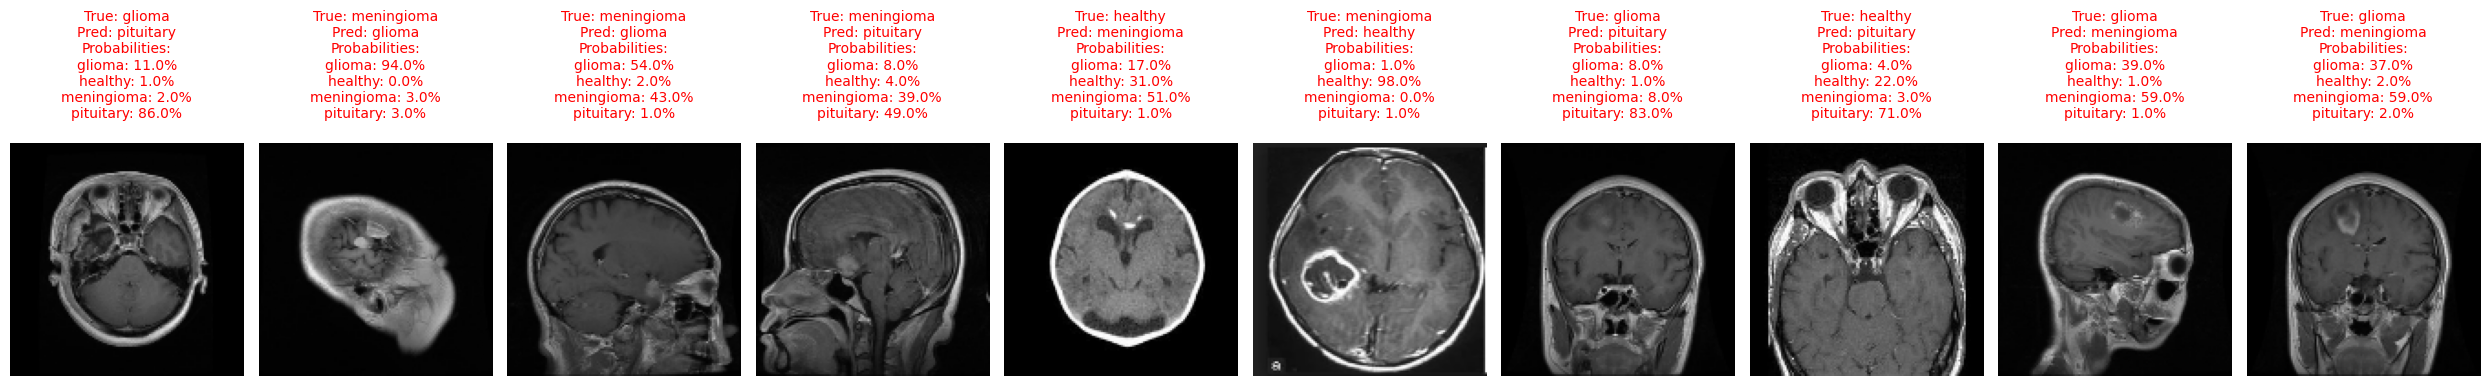


Misclassification analysis complete.


In [64]:
# --- Step 5: Evaluation and Uncertainty Prediction on misclassified images ---
print("\n--- Step 5: Evaluating the BNN and Predicting with Uncertainty on misclassified images ---")

# Ensure the model and guide are in evaluation mode
bnn_model.eval()
guide.eval()

# We will use the test loader to predict and find misclassified images
# Re-initialize the test loader to iterate through the entire test set
test_loader_full = DataLoader(test_dataset_transformed, batch_size=BATCH_SIZE, shuffle=False)

all_misclassified_images = []
all_misclassified_true_labels = []
all_misclassified_predicted_labels = []
all_misclassified_posterior_samples = [] # To store posterior samples for misclassified images

# Create a Pyro Predictive object to draw samples from the posterior
# For each test image, we'll perform 100 forward passes
predictive = Predictive(bnn_model, guide=guide, num_samples=100, return_sites=("obs", "_RETURN"))

# Iterate through the entire test loader to find misclassified images
print("\nIdentifying misclassified images...")
with torch.no_grad():
    for images, labels in tqdm(test_loader_full, desc="Processing test batches", unit="batch"):
        # Move data to GPU
        images = images.to("cuda")
        labels = labels.to("cuda")

        # Get predictions
        predictions = predictive(images)
        posterior_samples = predictions['obs']
        mode_predictions = torch.mode(posterior_samples, dim=0).values

        # Identify misclassified samples in the current batch
        misclassified_mask = (mode_predictions != labels)

        # Store misclassified images, labels, and posterior samples
        if misclassified_mask.sum() > 0:
            all_misclassified_images.append(images[misclassified_mask].cpu())
            all_misclassified_true_labels.append(labels[misclassified_mask].cpu())
            all_misclassified_predicted_labels.append(mode_predictions[misclassified_mask].cpu())
            all_misclassified_posterior_samples.append(posterior_samples[:, misclassified_mask].cpu())


# Concatenate all misclassified data
if len(all_misclassified_images) > 0:
    all_misclassified_images_tensor = torch.cat(all_misclassified_images, dim=0)
    all_misclassified_true_labels_tensor = torch.cat(all_misclassified_true_labels, dim=0)
    all_misclassified_predicted_labels_tensor = torch.cat(all_misclassified_predicted_labels, dim=0)
    all_misclassified_posterior_samples_tensor = torch.cat(all_misclassified_posterior_samples, dim=1) # Concatenate along the batch dimension

    print(f"\nFound {len(all_misclassified_images_tensor)} misclassified images out of {len(test_dataset_transformed)} test images.")

    # Display misclassified images with uncertainty
    num_images_to_display = min(10, len(all_misclassified_images_tensor)) # Display up to 10 misclassified images

    if num_images_to_display > 0:
        print(f"\nDisplaying {num_images_to_display} misclassified images with uncertainty:")
        fig, axes = plt.subplots(1, num_images_to_display, figsize=(25, 5))
        if num_images_to_display == 1:
            axes = [axes] # Make it iterable if there's only one image

        for i in range(num_images_to_display):
            img = all_misclassified_images_tensor[i].squeeze().permute(1, 2, 0).numpy() # Permute back to (H, W, C) for displaying
            true_label = label_encoder.inverse_transform([all_misclassified_true_labels_tensor[i].item()])[0]
            predicted_label = label_encoder.inverse_transform([all_misclassified_predicted_labels_tensor[i].item()])[0]

            # Calculate the frequency of each class in the posterior samples for this image
            sample_counts = torch.bincount(all_misclassified_posterior_samples_tensor[:, i], minlength=num_classes)
            total_samples = all_misclassified_posterior_samples_tensor.shape[0]
            probabilities = sample_counts.float() / total_samples

            # If the image has 3 channels, display as color; otherwise, display as grayscale
            if img.shape[-1] == 3:
                axes[i].imshow(img)
            else:
                axes[i].imshow(img, cmap='gray')

            title_text = f"True: {true_label}\nPred: {predicted_label}\n"
            uncertainty_text = "Probabilities:\n"
            for j, class_name in enumerate(class_names):
                uncertainty_text += f"{class_name}: {probabilities[j].item() * 100:.1f}%\n"

            axes[i].set_title(title_text + uncertainty_text, color='red', fontsize=10)
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified images to display.")

else:
    print("No misclassified images found in the test set.")

print("\nMisclassification analysis complete.")